## 问题提出

- 1max 问题：找出含有1的位数最多的n位串
- 适应度：含有1的个数
- target: 连续n个1
- 算法要求：遗传算法
- n=30
- 迭代的最大代数：100
- 种群规模=20
- 变异率=1%

## 构建代码

### 第一步：用字符串初始化20个30位串，每个n位串上的0，1都是随机获得

In [1]:
import numpy as  np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
def initial_random_parent(num_of_bit):
    """
    num_of_bit: 位串长
    """
    # 均匀分布
    a=np.random.uniform(size=(num_of_bit,))
    a=a>0.5
    a=(a+0).astype(str)
    ans="".join(a)
    return ans

In [3]:
## 测试
for _ in range(3):
    print(initial_random_parent(30))

110000010110000001110001110010
100101100001011100010100100010
000010110000000001001010001000


- 构造数据集：20个30位串

In [4]:
def traindata(num_of_group):
    """
    num of group: 种群规模
    """
    ans=[]
    for _ in range(num_of_group):
        ans.append(initial_random_parent(30))
    return ans

In [5]:
## 获得数据集
X_train=traindata(20)

In [6]:
## 检查数据集
print(len(X_train),len(X_train[0]))
print(X_train[2])

20 30
100100110101010111111111111110


### 第二步：定义适应度函数

In [7]:
def fitness(bit):
    """
    Input：
        bit:输入的位串
    output：
        这个bit的适应度
    """
    ans=bit.count("1")
    return ans

In [8]:
##测试
fitness("100000101")

3

### 第三步：定义随机取xi的函数（轮盘赌）
- 需要根据xi的适应度来定义他随机的权重
- 用到的函数`np.random.choice(list,weight)`

In [9]:
def choose_parent(fitnesslist,n=20):
    """
    Input:
        fitnesslist: 20个位串的适应度list
        n：位串的个数，默认为20
    Output：
        两个需要交叉的父代的index
    """
    # 归一化fitnesslist
    fitnesslist /= np.sum(fitnesslist)
    assert abs(np.sum(fitnesslist)-1)<0.0001
    index_a,index_b=np.random.choice(n,size=2,p=fitnesslist)## 采样是会重复的
    i=0
    while index_a==index_b or i<3:
        i=i+1
        index_b=np.random.choice(n,size=1,p=fitnesslist)
    return index_a,int(index_b)

In [10]:
## 测试choose_parent
a=[0,1,2,3,4,5,6,7,8,9]
for _ in range(4):
    print(choose_parent(a,n=10))

(8, 9)
(6, 4)
(8, 5)
(7, 5)


### 第四步：定义交叉的函数

In [11]:
def cross_gene(X_train,index_a,index_b):
    """
    Input: 
        X_train 数据集
        index_a,index_b:两个需要交叉的数据集
    Output：
        c1,c2:两个子代
    """
    X1=X_train[index_a]
    X2=X_train[index_b]
    ### 随机选择交叉点
    cross_index=np.random.randint(low=0,high=30,size=1)[0]
#     print("crossid:",cross_index)
    ans1=[]
    ans2=[]
    for i in range(30):
        if i<cross_index:
            ans1.append(X1[i])
            ans2.append(X2[i])
        else:
            ans1.append(X2[i])
            ans2.append(X1[i])
    ans1="".join(ans1)
    ans2="".join(ans2)
    return ans1,ans2

In [12]:
## 测试cross_gene
print(X_train[0])
print(X_train[1])
cross_gene(X_train,0,1)

001010110011101000001110000010
100111000010011000111011110101


('001010110011101000111011110101', '100111000010011000001110000010')

In [13]:
def mutate(gene,p=0.02):
    ans=[]
    for value in gene:
        a=np.random.random_sample()
        if a<p:
            ans.append(str(1-int(value)))
        else:
            ans.append(value)
    return "".join(ans)

In [14]:
###  测试mutate函数
for i in range(6):
    k=mutate(X_train[0],p=0.02)
    if k!= X_train[0]:
        print(i)

3
4
5


### 最后一步：循环训练

In [15]:
itermax=100
iternum=0

X_train=traindata(20) ## 获得20个第一代
fitnesslist=list(map(fitness,X_train))
fitmax=max(fitnesslist)
current_generation=X_train
while iternum<100 :
    if fitmax==30:
        break
    iternum+=1
#     print(fitnesslist)
    next_generation=[]
    assert len(current_generation)==20
    while len(next_generation)<len(current_generation):
#         print(fitnesslist)
        index_a,index_b=choose_parent(fitnesslist,n=20)
    
#         print(index_a,index_b)
        next_gene1,next_gene2=cross_gene(current_generation,index_a,index_b)
        next_generation.extend([next_gene1,next_gene2])
        
    next_generation=list(map(mutate,next_generation))
    current_generation=next_generation
    fitnesslist=list(map(fitness,next_generation))
    fitmax=max(fitnesslist)
    if iternum % 20==0:
        print("iternum:{},fitmax={}".format(iternum,fitmax))
    
max_index=fitnesslist.index(fitmax)
print(current_generation[max_index])


iternum:20,fitmax=20
iternum:40,fitmax=22
iternum:60,fitmax=23
iternum:80,fitmax=24
iternum:100,fitmax=24
100111111011111111111110101101


### 包装成类

In [16]:
class GA:
    def __init__(self,num_of_bit,num_of_group,mutate_value,fitfun=1):
        self.num_of_bit=num_of_bit
        self.num_of_group=num_of_group
        self.mutate_value=mutate_value
        self.fitfun=fitfun
        
    def initial_random_parent(self,num_of_bit):
        """
        num_of_bit: 位串长
        """
        # 均匀分布
        a=np.random.uniform(size=(num_of_bit,))
        a=a>0.5
        a=(a+0).astype(str)
        ans="".join(a)
        return ans

    def traindata(self,num_of_group):
        """
        num of group: 种群规模
        """
        ans=[]
        for _ in range(num_of_group):
            ans.append(initial_random_parent(30))
        return ans
    
    def fitness(self,bit):
        """
        Input：
            bit:输入的位串
        output：
            这个bit的适应度
        """
        ans=bit.count("1")
        return ans
    
    def fitness2(self,bit):
        """
        Input：
            bit:输入的位串
        output：
            这个bit的适应度
        """
        ans=bit.count("1")+50
        return ans
    
    def choose_parent(self,fitnesslist,n=20):
        """
        Input:
            fitnesslist: 20个位串的适应度list
            n：位串的个数，默认为20
        Output：
            两个需要交叉的父代的index
        """
        # 归一化fitnesslist
        fitnesslist /= np.sum(fitnesslist)
        assert abs(np.sum(fitnesslist)-1)<0.0001
        index_a,index_b=np.random.choice(n,size=2,p=fitnesslist)## 采样是会重复的
        i=0
        if self.fitfun!=3:
            while index_a==index_b or i<2 :
                i=i+1
                index_b=np.random.choice(n,size=1,p=fitnesslist)
        return index_a,int(index_b)

    def cross_gene(self,X_train,index_a,index_b):
        """
        Input: 
            X_train 数据集
            index_a,index_b:两个需要交叉的数据集
        Output：
            c1,c2:两个子代
        """
        X1=X_train[index_a]
        X2=X_train[index_b]
        ### 随机选择交叉点
        cross_index=np.random.randint(low=0,high=30,size=1)[0]
    #     print("crossid:",cross_index)
        ans1=[]
        ans2=[]
        for i in range(30):
            if i<cross_index:
                ans1.append(X1[i])
                ans2.append(X2[i])
            else:
                ans1.append(X2[i])
                ans2.append(X1[i])
        ans1="".join(ans1)
        ans2="".join(ans2)
        return ans1,ans2
    
    
    def mutate(self,gene):
        p=self.mutate_value
        ans=[]
        for value in gene:
            a=np.random.random_sample()
            if a<p:
                ans.append(str(1-int(value)))
            else:
                ans.append(value)
        return "".join(ans)
    
    def predict(self,itermax,Verbose=True):
        if self.fitfun==1:
            pass
        elif self.fitfun==2:
            self.fitness=self.fitness2
            
        iternum=0

        X_train=self.traindata(self.num_of_group) ## 获得20个第一代        
        fitnesslist=list(map(self.fitness,X_train))
        if self.fitfun==3:
            average=np.sum(fitnesslist)/len(fitnesslist)
            mask=list(map(lambda x: x>=average,fitnesslist))
            fitnesslist =np.multiply(fitnesslist,mask)
            fitnesslist =fitnesslist.tolist()
        fitmax=max(fitnesslist)
        current_generation=X_train
        
        v_best=[fitmax]
        v_aver=[np.sum(fitnesslist)/len(fitnesslist)]
        while iternum<itermax :
#             if fitmax==self.num_of_bit:
#                 break
                
            iternum+=1
            
            next_generation=[]
            assert len(current_generation)==self.num_of_group
            
            while len(next_generation)<len(current_generation):
#                 print(fitnesslist)
#                 print(type(fitnesslist))
                index_a,index_b=self.choose_parent(fitnesslist,n=self.num_of_group)

        #         print(index_a,index_b)
                next_gene1,next_gene2=self.cross_gene(current_generation,index_a,index_b)
                next_generation.extend([next_gene1,next_gene2])
#             print(next_generation)
            next_generation=list(map(self.mutate,next_generation))
            current_generation=next_generation
            fitnesslist=list(map(self.fitness,next_generation))
            if self.fitfun==3:
                average=np.sum(fitnesslist)/len(fitnesslist)
                mask=list(map(lambda x: x>=average,fitnesslist))
                fitnesslist =np.multiply(fitnesslist,mask)
                fitnesslist = fitnesslist.tolist()
            fitmax=max(fitnesslist)
            
            v_best.append(fitmax)
            v_aver.append(np.sum(fitnesslist)/len(fitnesslist))
        if Verbose:
            # 定义figure
            plt.figure()
            # 分隔figure
            gs = gridspec.GridSpec(1, 2)
            ax1 = plt.subplot(gs[0,0])
            ax2 = plt.subplot(gs[0,1])

            # 绘制图像
            b_x=np.arange(itermax+1)
            ax1.plot(b_x,v_best)
            ax1.set_title("best_num for 1")
            ax2.plot(b_x,v_aver)
            ax2.set_title("average_num for 1")
            plt.show()
        self.max1=max(v_best)
        self.v_best=v_best       
        max_index=fitnesslist.index(fitmax)
        return 

- 1.画出最好的个体，以及种群平均适应度随着代数变化的图形

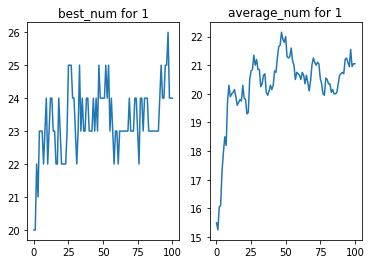

In [17]:
model=GA(num_of_bit=30,num_of_group=20,mutate_value=0.01)
model.predict(itermax=100)

- 2.做50次仿真，你会得到50个best图，画出这50个图的平均。 记100代最好的50个适应值的平均为$f_{aver}(x^*)$,则$f_{aver}(x^*)$是多少

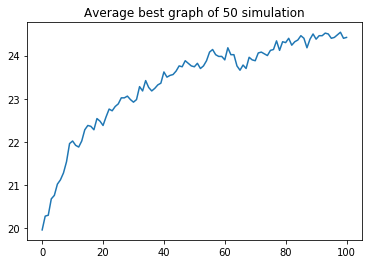

50次最好的适应值为26.7


In [18]:
ans_best=np.zeros(101)
f_star=0

for i in range(50):
    model=GA(num_of_bit=30,num_of_group=20,mutate_value=0.01)
    model.predict(itermax=100,Verbose=False)
    ans_best +=np.array(model.v_best)
    f_star += model.max1
ans_best=(ans_best/50).tolist()
x=np.arange(101)
plt.figure()
plt.plot(x,ans_best)
plt.title("Average best graph of 50 simulation")
plt.show()

print("50次最好的适应值为{}".format(f_star/50))

- 3. 种群规模编程40，重复2，与2相比，$f_{aver}(x^*)$有什么区别

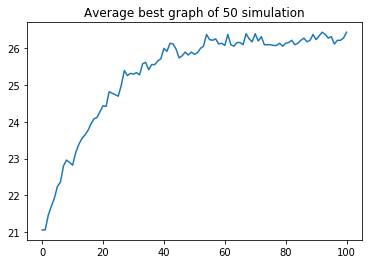

50次最好的适应值为28.44


In [19]:
ans_best=np.zeros(101)
f_star=0

for i in range(50):
    model=GA(num_of_bit=30,num_of_group=40,mutate_value=0.01)
    model.predict(itermax=100,Verbose=False)
    ans_best +=np.array(model.v_best)
    f_star += model.max1
ans_best=(ans_best/50).tolist()
x=np.arange(101)
plt.figure()
plt.plot(x,ans_best)
plt.title("Average best graph of 50 simulation")
plt.show()

print("50次最好的适应值为{}".format(f_star/50))

- 4 规模为20，变异率为5%，重复2，有什么区别

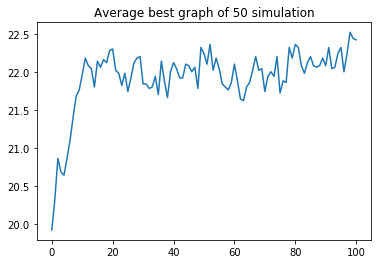

50次最好的适应值为25.86


In [20]:
ans_best=np.zeros(101)
f_star=0
for i in range(50):
    model=GA(num_of_bit=30,num_of_group=20,mutate_value=0.05)
    model.predict(itermax=100,Verbose=False)
    ans_best +=np.array(model.v_best)
    f_star += model.max1
ans_best=(ans_best/50).tolist()
x=np.arange(101)
plt.figure()
plt.plot(x,ans_best)
plt.title("Average best graph of 50 simulation")
plt.show()

print("50次最好的适应值为{}".format(f_star/50))

- 5 变异率为0%，重复2，有什么区别

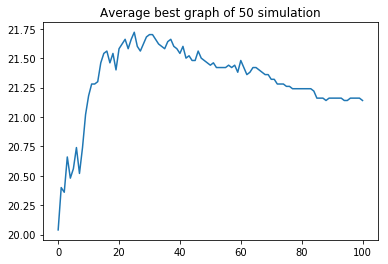

50次最好的适应值为23.16


In [21]:
ans_best=np.zeros(101)
f_star=0
for i in range(50):
    model=GA(num_of_bit=30,num_of_group=20,mutate_value=0)
    model.predict(itermax=100,Verbose=False)
    ans_best +=np.array(model.v_best)
    f_star += model.max1
ans_best=(ans_best/50).tolist()
x=np.arange(101)
plt.figure()
plt.plot(x,ans_best)
plt.title("Average best graph of 50 simulation")
plt.show()

print("50次最好的适应值为{}".format(f_star/50))

- 6 将适应度改为 等于1的数+50而不是等于1的数，重复2

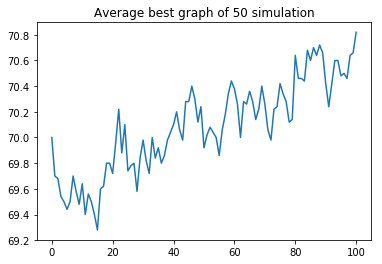

50次最好的适应值为73.64


In [22]:
ans_best=np.zeros(101)
f_star=0
for i in range(50):
    model=GA(num_of_bit=30,num_of_group=20,mutate_value=0.01,fitfun=2)
    model.predict(itermax=100,Verbose=False)
    ans_best +=np.array(model.v_best)
    f_star += model.max1
ans_best=(ans_best/50).tolist()
x=np.arange(101)
plt.figure()
plt.plot(x,ans_best)
plt.title("Average best graph of 50 simulation")
plt.show()

print("50次最好的适应值为{}".format(f_star/50))

- 7. 适应度函数改为 低于平均的为0，与2比有什么区别

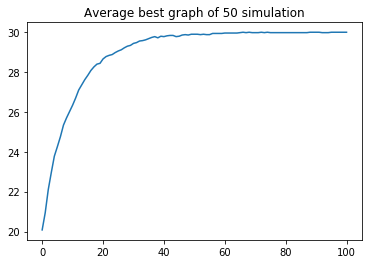

50次最好的适应值为30.0


In [23]:
ans_best=np.zeros(101)
f_star=0
for i in range(50):
    model=GA(num_of_bit=30,num_of_group=20,mutate_value=0.01,fitfun=3)
    model.predict(itermax=100,Verbose=False)
    ans_best +=np.array(model.v_best)
    f_star += model.max1
ans_best=(ans_best/50).tolist()
x=np.arange(101)
plt.figure()
plt.plot(x,ans_best)
plt.title("Average best graph of 50 simulation")
plt.show()

print("50次最好的适应值为{}".format(f_star/50))